In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import sklearn
sklearn.set_config(transform_output="pandas")
import warnings
warnings.filterwarnings('ignore')

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.linear_model import LinearRegression


# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import VotingRegressor, StackingRegressor

from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import accuracy_score, root_mean_squared_error,root_mean_squared_log_error


# tunning hyperparamters model
import optuna
import shap


# from tqdm import tqdm

In [2]:
filetrain = 'data/train.csv'
train = pd.read_csv(filetrain)
X, y = train.drop('SalePrice', axis=1), train['SalePrice']
testfile = 'data/test.csv'
test =  pd.read_csv(testfile)

## Начало

In [3]:
pd.DataFrame(data={'NaN_count': X.isna().sum(), 'data_type':X.dtypes})

,NaN_count,data_type
Id,0,int64
MSSubClass,0,int64
MSZoning,0,object
LotFrontage,259,float64
LotArea,0,int64
...,...,...
MiscVal,0,int64
MoSold,0,int64
YrSold,0,int64
SaleType,0,object


In [5]:
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [7]:
t = pd.DataFrame(data={'NaN_count': X.isna().sum(), 'data_type':X.dtypes})
t.loc[t['NaN_count'] > 0]

,NaN_count,data_type
LotFrontage,259,float64
Alley,1369,object
MasVnrType,872,object
MasVnrArea,8,float64
BsmtQual,37,object
BsmtCond,37,object
BsmtExposure,38,object
BsmtFinType1,37,object
BsmtFinType2,38,object
Electrical,1,object


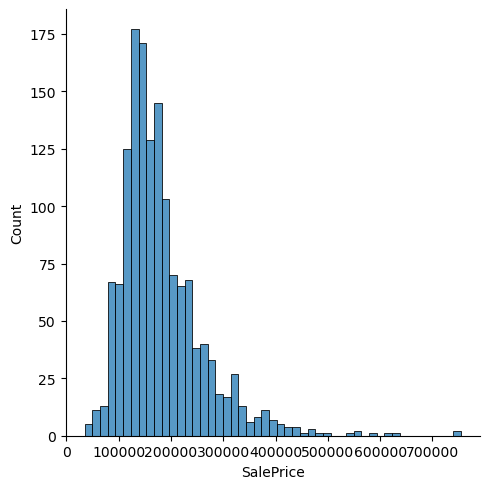

In [6]:
sns.displot(train['SalePrice'])

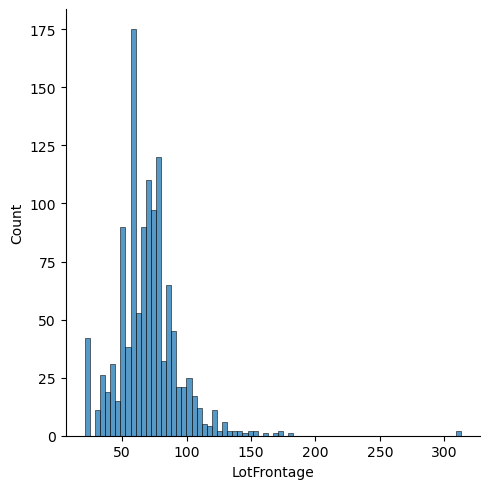

In [7]:
sns.displot(train['LotFrontage'])

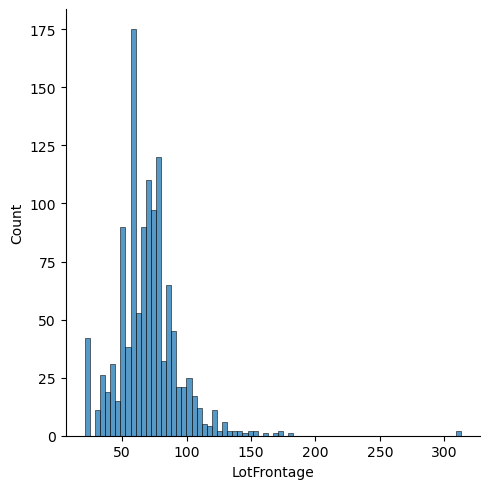

In [8]:
sns.displot(train['LotFrontage'])

<Axes: xlabel='LotArea', ylabel='LotFrontage'>

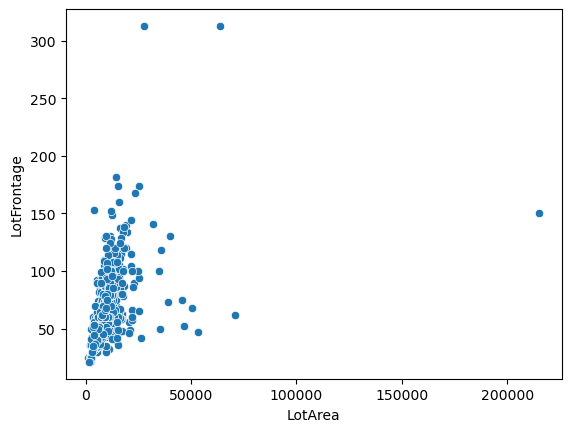

In [9]:
sns.scatterplot(data = train , x = 'LotArea' , y = 'LotFrontage')

<Axes: xlabel='SalePrice', ylabel='LotFrontage'>

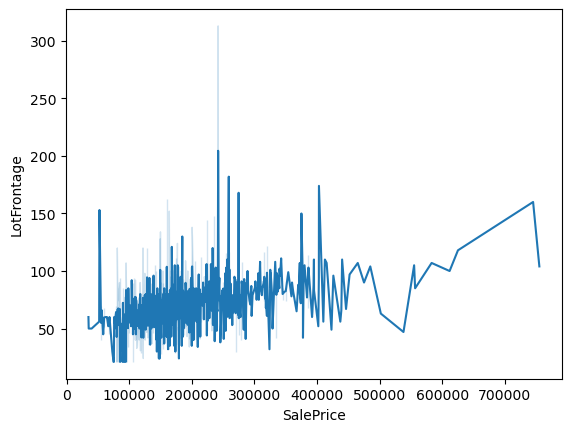

In [10]:
sns.lineplot(data = train , x = 'SalePrice' , y = 'LotFrontage')


In [5]:
num_features = train.select_dtypes(exclude='object')
cat_features = train.select_dtypes(include='object')

## Preprocessering

In [4]:
t = pd.DataFrame(data={'NaN_count': X.isna().sum(), 'data_type':X.dtypes})

cools_to_fill = ['Alley', 'PoolQC','Fence','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                 'FireplaceQu','GarageType', 'GarageFinish','GarageQual','GarageCond','MasVnrType']
drop_colums = ['MiscFeature']

garage_YER = ['GarageYrBlt']

Elect = ['Electrical']

Medin = ['LotFrontage']

MasVn = ['MasVnrArea']

fill_na = ColumnTransformer(
     transformers = [
        ('fillna' , SimpleImputer(strategy='constant', fill_value='NO') , cools_to_fill),
        ('garage_YER' , SimpleImputer(strategy='constant', fill_value= -1) , garage_YER),
        ('drop_col' , 'drop', drop_colums ),
        ('mod_electrical', SimpleImputer(strategy='most_frequent'), Elect),
        ('Median_value', SimpleImputer(strategy='median'), Medin),
        ('MasVn_zero', SimpleImputer(strategy='constant', fill_value= 0 ), MasVn)   
     ],
     verbose_feature_names_out = False,
     remainder = 'passthrough')

class MasVnrType_modify(BaseEstimator, TransformerMixin): 
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()

        ff = ((X_copy['MasVnrArea'] == 0)  & (X_copy['MasVnrType'] != 'NO'))
        X_copy.loc[ff,'MasVnrArea'] = X_copy['MasVnrArea'].loc[X_copy['MasVnrType'] == 'Stone'].median()
        
        f = ((X_copy['MasVnrArea'] != 0)  & (X_copy['MasVnrType'] == 'NO'))
        X_copy.loc[f,'MasVnrType'] = 'BrkFace'
        
        return X_copy

MasVnrType = ColumnTransformer(
    transformers = [
        ('MasVnrType_modify', MasVnrType_modify(), ['MasVnrArea','MasVnrType']),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

value_type = pd.DataFrame(data={'data_type':X.dtypes}).loc[t['data_type'] != object]

list_standart_scaler = value_type.index.to_list()
ordinal_encoding_columns = ['PoolQC', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'HeatingQC', 'CentralAir', 'KitchenQual', 'PavedDrive', 'Functional']
target_encoding_columns = ['Alley', 'GarageType', 'MasVnrType', 'Electrical', 'MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'SaleType', 'SaleCondition', 'Fence']

super_target = ordinal_encoding_columns+target_encoding_columns

my_encoder = ColumnTransformer(
    [
        ('ordinal_encoding', OrdinalEncoder(), super_target),
        ('scaling_num_columns', StandardScaler(), list_standart_scaler),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

preprocessor = Pipeline(
    [
        ('fill_na', fill_na),
        ('MasVnrType',MasVnrType),
        ('Encoding_and_scaling',my_encoder)
        # (),
        # ()
        
    ]
)

## First Model build

### SHAP

In [13]:
shap.initjs()
X_copy = X.copy()
X_copy = preprocessor.fit_transform(X_copy)


model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=42)
model.fit(X_copy, y, verbose=False, plot=False)

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_copy)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_copy.iloc[0,:])

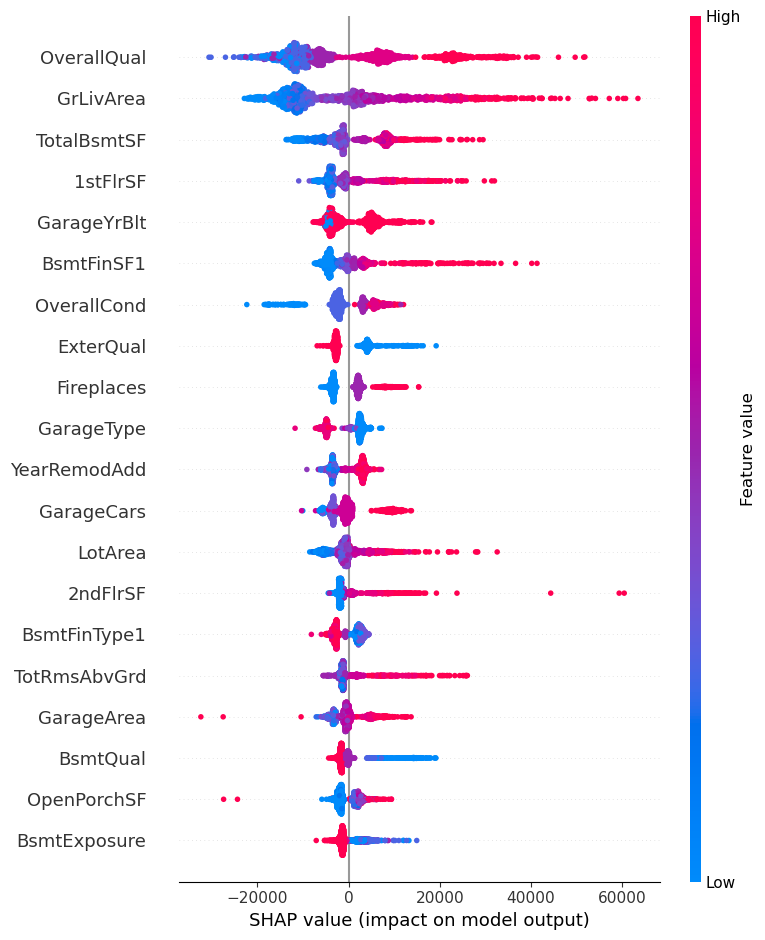

In [15]:
shap.summary_plot(shap_values, X_copy)

### Random

In [5]:
X_copy = X.copy()

X_copy['random'] = np.random.normal(0,0.5, size=X_copy.shape[0])
rf = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=2)

X_RF = preprocessor.fit_transform(X_copy)

rf.fit(X_RF, y)

result = pd.Series(dict(zip(X_RF.columns, rf.feature_importances_))).sort_values(key=lambda x: abs(x), ascending=False).to_frame().round(6)

result.loc[result[0] < 0.0005].index.to_list()
pd.set_option('display.max_rows', 80)

result.index.to_list().index('random')
OK = result.index.to_list()[:result.index.to_list().index('random')]

In [6]:
result.loc[result[0] < 0.0005].index.to_list()
pd.set_option('display.max_rows', 80)

result.index.to_list().index('random')
OK = result.index.to_list()[:result.index.to_list().index('random')]
NOT_OK = result.index.to_list()[1+result.index.to_list().index('random'):]
OK

['OverallQual',
 'GrLivArea',
 '2ndFlrSF',
 'GarageCars',
 'TotalBsmtSF',
 '1stFlrSF',
 'BsmtFinSF1',
 'FullBath',
 'GarageArea',
 'TotRmsAbvGrd',
 'MasVnrArea',
 'BsmtQual',
 'LotArea',
 'YearBuilt',
 'ExterQual',
 'YearRemodAdd',
 'GarageType',
 'Neighborhood',
 'Fireplaces',
 'KitchenQual',
 'Id',
 'MoSold',
 'LotShape',
 'LotFrontage',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'WoodDeckSF',
 'BsmtUnfSF',
 'GarageYrBlt',
 'BedroomAbvGr',
 'CentralAir',
 'MSZoning',
 'BsmtHalfBath',
 'RoofMatl',
 'ExterCond',
 'YrSold',
 'LotConfig',
 'OpenPorchSF']

## Feature analysis + drop

#### Решили оставить самые важные колонки


In [7]:
cools_to_fill = ['Alley', 'PoolQC','Fence','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                 'FireplaceQu','GarageType', 'GarageFinish','GarageQual','GarageCond','MasVnrType']
drop_colums = ['MiscFeature']

garage_YER = ['GarageYrBlt']

Elect = ['Electrical']

Medin = ['LotFrontage']

MasVn = ['MasVnrArea']

fill_na = ColumnTransformer(
     transformers = [
        ('fillna' , SimpleImputer(strategy='constant', fill_value='NO') , cools_to_fill),
        ('garage_YER' , SimpleImputer(strategy='constant', fill_value= -1) , garage_YER),
        ('drop_col' , 'drop', drop_colums ),
        ('mod_electrical', SimpleImputer(strategy='most_frequent'), Elect),
        ('Median_value', SimpleImputer(strategy='median'), Medin),
        ('MasVn_zero', SimpleImputer(strategy='constant', fill_value= 0 ), MasVn)   
     ],
     verbose_feature_names_out = False,
     remainder = 'passthrough')

class MasVnrType_modify(BaseEstimator, TransformerMixin): 
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()

        ff = ((X_copy['MasVnrArea'] == 0)  & (X_copy['MasVnrType'] != 'NO'))
        X_copy.loc[ff,'MasVnrArea'] = X_copy['MasVnrArea'].loc[X_copy['MasVnrType'] == 'Stone'].median()
        
        f = ((X_copy['MasVnrArea'] != 0)  & (X_copy['MasVnrType'] == 'NO'))
        X_copy.loc[f,'MasVnrType'] = 'BrkFace'
        
        return X_copy

MasVnrType = ColumnTransformer(
    transformers = [
        ('MasVnrType_modify', MasVnrType_modify(), ['MasVnrArea','MasVnrType']),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)
t = pd.DataFrame(data={'NaN_count': X.isna().sum(), 'data_type':X.dtypes})
value_type = pd.DataFrame(data={'data_type':X.dtypes}).loc[t['data_type'] != object]

list_standart_scaler = value_type.index.to_list()
ordinal_encoding_columns = ['PoolQC', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'HeatingQC', 'CentralAir', 'KitchenQual', 'PavedDrive', 'Functional']
target_encoding_columns = ['Alley', 'GarageType', 'MasVnrType', 'Electrical', 'MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'SaleType', 'SaleCondition', 'Fence']

super_target = ordinal_encoding_columns+target_encoding_columns

my_encoder = ColumnTransformer(
    [
        ('ordinal_encoding', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), super_target),
        # ('target_encoding_columns', TargetEncoder(), target_encoding_columns),
        ('scaling_num_columns', StandardScaler(), list_standart_scaler),
        # ('target_encoding_columns', TargetEncoder(), super_target)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)


super_drop = ColumnTransformer(
    [
        ('dropdropdrop', 'drop', NOT_OK ),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)



preprocessor = Pipeline(
    [
        ('fill_na', fill_na),
        ('MasVnrType',MasVnrType),
        ('Encoding_and_scaling',my_encoder),
        ('drop+',super_drop),
        # ()
        
    ]
)

## Main model + Pipeline

In [11]:
from catboost import CatBoostRegressor

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


model = CatBoostRegressor(iterations=3000, learning_rate=0.04,depth=4, random_seed=42)

In [81]:
model = CatBoostRegressor(iterations=3000, learning_rate=0.04,depth=4, random_seed=42)
ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

ml_pipeline.fit(X_train,y_train)

0:	learn: 75527.0190741	total: 408us	remaining: 1.23s
1:	learn: 73737.0808531	total: 919us	remaining: 1.38s
2:	learn: 71894.5217557	total: 1.2ms	remaining: 1.19s
3:	learn: 70090.6772690	total: 1.46ms	remaining: 1.1s
4:	learn: 68427.2223671	total: 1.74ms	remaining: 1.04s
5:	learn: 67013.3679493	total: 2.01ms	remaining: 1s
6:	learn: 65459.7772556	total: 2.28ms	remaining: 975ms
7:	learn: 64043.9646103	total: 2.55ms	remaining: 955ms
8:	learn: 62584.1815766	total: 2.84ms	remaining: 943ms
9:	learn: 61385.1464610	total: 3.12ms	remaining: 934ms
10:	learn: 60063.6586848	total: 3.4ms	remaining: 924ms
11:	learn: 58693.2828907	total: 3.68ms	remaining: 917ms
12:	learn: 57489.2801617	total: 4.02ms	remaining: 923ms
13:	learn: 56331.8728712	total: 4.31ms	remaining: 919ms
14:	learn: 55211.6987917	total: 4.59ms	remaining: 914ms
15:	learn: 54130.5437630	total: 4.91ms	remaining: 915ms
16:	learn: 53062.4338529	total: 5.2ms	remaining: 913ms
17:	learn: 52146.9511208	total: 5.49ms	remaining: 909ms
18:	learn: 

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('fill_na',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('fillna',
                                                                   SimpleImputer(fill_value='NO',
                                                                                 strategy='constant'),
                                                                   ['Alley',
                                                                    'PoolQC',
                                                                    'Fence',
                                                                    'BsmtQual',
                                                                    'BsmtCond',
                                                                    'BsmtExposure',
                                                                    'BsmtFinType1',
                                                                    'BsmtFinType2',
                                                                    'FireplaceQu',
                                                                    'GarageType',
                                                                    'GarageFinish',
                                                                    'GarageQual',
                                                                    'GarageCond',
                                                                    'MasVnrType']...
                                                                    'BsmtFullBath',
                                                                    'Exterior2nd',
                                                                    'OverallCond',
                                                                    'Fence',
                                                                    'BsmtExposure',
                                                                    'BsmtFinType1',
                                                                    'RoofStyle',
                                                                    'BsmtFinType2',
                                                                    'BsmtCond',
                                                                    '3SsnPorch',
                                                                    'MiscVal',
                                                                    'GarageFinish',
                                                                    'EnclosedPorch',
                                                                    'BsmtFinSF2',
                                                                    'Heating',
                                                                    'Foundation',
                                                                    'HouseStyle',
                                                                    'MSSubClass',
                                                                    'Condition2', ...])],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7f6fed0837c0>)])

In [82]:
y_pred = ml_pipeline.predict(X_valid)


root_mean_squared_error(y_true=y_valid, y_pred=y_pred)

28455.997824568774

## OPTUNE

In [17]:
ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor())
    ]
)


def objective(trial):
    
    # Параметры самой модели
    model_params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800, 25),
        'max_depth' : trial.suggest_int('max_depth', 2, 8, 1),
        'random_state': trial.suggest_int('random_state', 42, 42, 1)
    }
    
    
    ml_pipeline.named_steps['model'].set_params(**model_params)

    # Создание сплитов для кросс-валидации
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    # Вычисление метрик точности с использованием кросс-валидации
    scores = cross_val_score(ml_pipeline, X, y, cv=cv)
    
    accuracy = scores.mean()
    
    return accuracy


# Создание объекта для проведения оптимизации
study = optuna.create_study(direction='maximize')


# Запуск оптимизации
study.optimize(objective, n_trials=200)


# Вывод результатов
best_params = study.best_params
best_value = study.best_value


print(f"Лучшие параметры: {best_params}")
print(f"Лучшее значение: {best_value}")

## CROSS VALIDATION

In [13]:
cat = CatBoostRegressor(iterations=3000, learning_rate=0.04366383,depth=7, random_seed=42)
RFR = RandomForestRegressor(max_depth=6, n_estimators=750)
VC = VotingRegressor(
    [
        ('RFR', RFR),
        ('CATBoost', cat)
    ]
)

STC = StackingRegressor(
    estimators=[
        ('RFR',RFR),
        ('catboost',cat)
    ])


ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', STC)
    ]
)

ml_pipeline.fit(X_train,y_train)

0:	learn: 75124.0850540	total: 56.8ms	remaining: 2m 50s
1:	learn: 73070.6112961	total: 59ms	remaining: 1m 28s
2:	learn: 71161.9627158	total: 61.5ms	remaining: 1m 1s
3:	learn: 69283.8835955	total: 67.2ms	remaining: 50.3s
4:	learn: 67566.4242050	total: 68.7ms	remaining: 41.1s
5:	learn: 65840.4969141	total: 70.5ms	remaining: 35.2s
6:	learn: 64273.7976933	total: 72.1ms	remaining: 30.8s
7:	learn: 62523.3544811	total: 73.8ms	remaining: 27.6s
8:	learn: 60984.2491554	total: 75.6ms	remaining: 25.1s
9:	learn: 59676.7287069	total: 77.1ms	remaining: 23s
10:	learn: 58313.0130280	total: 78.8ms	remaining: 21.4s
11:	learn: 56863.8070855	total: 80.5ms	remaining: 20s
12:	learn: 55608.7284126	total: 83.4ms	remaining: 19.2s
13:	learn: 54326.2798259	total: 85.8ms	remaining: 18.3s
14:	learn: 53205.9678512	total: 88ms	remaining: 17.5s
15:	learn: 52181.4276937	total: 89.5ms	remaining: 16.7s
16:	learn: 50948.6025945	total: 91.1ms	remaining: 16s
17:	learn: 49861.9232134	total: 94ms	remaining: 15.6s
18:	learn: 4

KeyboardInterrupt: 

In [22]:
y_pred = ml_pipeline.predict(X_valid)


root_mean_squared_error(y_true=y_valid, y_pred=y_pred)

27494.85064204261

In [ ]:
models = {'catboost':cat, 'VC':VC, 'STC':STC}

cv = KFold(n_splits=5, random_state=42, shuffle=True)
d = []
for name, model in models.items():
    ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        (name, model)
    ]
)
    ml_pipeline.fit(X_train, y_train)

    train = root_mean_squared_error(y_train, ml_pipeline.predict(X_train))
    valid = root_mean_squared_error(y_valid, ml_pipeline.predict(X_valid))
    

    
    cross_validation_result = cross_val_score(
        ml_pipeline,
        X,
        y,
        cv = cv,)
    
    x = [name, train, valid, cross_validation_result.mean()]
    d.append(x)

final = pd.DataFrame(d).rename(columns={0:'Model',1:'train score',2:'valid score',3:'cross validation'}).sort_values('cross validation', ascending = False)

In [97]:
final

,Model,train score,valid score,cross validation
0,catboost,343.415844,27869.244690,0.863100
2,RFR,28336.254536,35096.771292,0.783503
1,linearR,32588.159126,36569.493257,0.712675


## Log END

In [16]:
y_log = np.log(y)


In [14]:
cat = CatBoostRegressor(iterations=3000, learning_rate=0.04366383,depth=7, random_seed=42)
RFR = RandomForestRegressor(max_depth=6, n_estimators=750)

STC = StackingRegressor(
    estimators=[
        ('RFR',RFR),
        ('catboost',cat)
    ])
ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', STC)
    ]
)

In [17]:
ml_pipeline.fit(X, y_log)

0:	learn: 0.3880185	total: 4.1ms	remaining: 12.3s
1:	learn: 0.3773046	total: 9.22ms	remaining: 13.8s
2:	learn: 0.3666023	total: 45.2ms	remaining: 45.1s
3:	learn: 0.3567587	total: 48.3ms	remaining: 36.2s
4:	learn: 0.3472819	total: 63.4ms	remaining: 38s
5:	learn: 0.3380207	total: 65.3ms	remaining: 32.6s
6:	learn: 0.3289463	total: 68.1ms	remaining: 29.1s
7:	learn: 0.3201816	total: 82.3ms	remaining: 30.8s
8:	learn: 0.3120835	total: 99.5ms	remaining: 33.1s
9:	learn: 0.3041916	total: 102ms	remaining: 30.6s
10:	learn: 0.2970011	total: 115ms	remaining: 31.2s
11:	learn: 0.2900268	total: 119ms	remaining: 29.5s
12:	learn: 0.2829576	total: 128ms	remaining: 29.4s
13:	learn: 0.2763757	total: 130ms	remaining: 27.7s
14:	learn: 0.2700856	total: 132ms	remaining: 26.3s
15:	learn: 0.2644165	total: 134ms	remaining: 25s
16:	learn: 0.2586397	total: 145ms	remaining: 25.4s
17:	learn: 0.2532052	total: 147ms	remaining: 24.4s
18:	learn: 0.2473426	total: 150ms	remaining: 23.5s
19:	learn: 0.2416106	total: 152ms	rem

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('fill_na',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('fillna',
                                                                   SimpleImputer(fill_value='NO',
                                                                                 strategy='constant'),
                                                                   ['Alley',
                                                                    'PoolQC',
                                                                    'Fence',
                                                                    'BsmtQual',
                                                                    'BsmtCond',
                                                                    'BsmtExposure',
                                                                    'BsmtFinType1',
                                                                    'BsmtFinType2',
                                                                    'FireplaceQu',
                                                                    'GarageType',
                                                                    'GarageFinish',
                                                                    'GarageQual',
                                                                    'GarageCond',
                                                                    'MasVnrType']...
                                                                    'Heating',
                                                                    'BsmtCond',
                                                                    'PavedDrive',
                                                                    '3SsnPorch',
                                                                    'BsmtFinType2',
                                                                    'MiscVal',
                                                                    'HeatingQC',
                                                                    'HalfBath',
                                                                    'KitchenAbvGr',
                                                                    'Functional',
                                                                    'Foundation',
                                                                    'Alley', ...])],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 StackingRegressor(estimators=[('RFR',
                                                RandomForestRegressor(max_depth=6,
                                                                      n_estimators=750)),
                                               ('catboost',
                                                <catboost.core.CatBoostRegressor object at 0x7f12d57abac0>)]))])

In [22]:
y_pred_log = ml_pipeline.predict(test)

In [24]:
y_pred_final = np.exp(y_pred_log)

In [51]:
id = np.arange(1461, 2920)

In [52]:
submission = pd.DataFrame(y_pred_final).rename(columns={0:'SalePrice'}).set_index(id)

In [53]:
submission

,SalePrice
1461,127252.184363
1462,167027.270094
1463,190307.241796
1464,197416.098607
1465,198059.647134
...,...
2915,70657.706475
2916,83468.466505
2917,165541.405076
2918,100501.029900


In [54]:
submission.to_csv('submission.csv')

In [ ]:
import joblib
# joblib.dump(ml_pipeline_stc2, 'aux/model_stc.pkl')
joblib.dump(ml_pipeline_cat_smote, 'aux/cat_smote.pkl')